In [6]:
import time
import math
import random
import numpy as np
from pyspark.sql import SparkSession
from pyspark import SparkConf

# ---------------- Support ----------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

def fuzz_param(param, IN):
    return random.uniform(param * (1 - IN), param * (1 + IN))

def safe_uniform(a=0.0, b=1.0, eps=1e-12):
    val = random.uniform(a, b)
    return min(b - eps, max(a + eps, val))

# ---------------- Distributions ----------------
def generate_fuzzed_neutrosophic_erlang(k, expected_value, IN, size):
    theta_mean = k / expected_value
    results = []
    for _ in range(size):
        theta_f = fuzz_param(theta_mean, IN)
        xN = sum(-math.log(1 - safe_uniform()) / theta_f for _ in range(k))
        results.append(xN)
    return np.array(results)

def generate_fuzzed_gamma(alpha, beta, IN, k, size):
    results = []
    for _ in range(size):
        alpha_rand = max(0.01, fuzz_param(alpha, IN))
        beta_rand = max(0.01, fuzz_param(beta, IN / k))
        value = random.gammavariate(alpha_rand, 1 / beta_rand)
        results.append(value)
    return np.array(results)

def generate_fuzzed_gaussian(mu, sigma, IN_mu, IN_sigma, size):
    if size == 0:
        return np.array([])
    data = []
    for _ in range(max(1, size // 2)):
        fuzzed_mu = fuzz_param(mu, IN_mu)
        fuzzed_sigma = max(1e-6, fuzz_param(sigma, IN_sigma))
        u1, u2 = safe_uniform(), safe_uniform()
        z0 = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
        z1 = math.sqrt(-2 * math.log(u1)) * math.sin(2 * math.pi * u2)
        data.append(fuzzed_mu + fuzzed_sigma * z0)
        if len(data) < size:
            data.append(fuzzed_mu + fuzzed_sigma * z1)
    return np.array(data[:size])

def generate_erlang_default(k, lam, size):
    return np.random.gamma(k, 1/lam, size)

def generate_gamma_default(alpha, beta, size):
    return np.random.gamma(alpha, 1/beta, size)

def generate_gaussian_default(mu, sigma, size):
    return np.random.normal(mu, sigma, size)

# ---------------- Benchmark utils ----------------
def benchmark_python(func, size, repeat=1):
    times = []
    for _ in range(repeat):
        start = time.time()
        _ = func(size)
        end = time.time()
        times.append(end - start)
    return np.mean(times), np.std(times)

def benchmark_spark(spark, func, size, repeat=1):
    times = []
    num_partitions = min(200, max(10, size // 50000))  # Tối ưu số partitions
    
    for _ in range(repeat):
        start = time.time()
        # Tạo RDD với số partitions tối ưu
        rdd = spark.sparkContext.parallelize(range(size), numSlices=num_partitions)
        # Batch processing thay vì từng element
        batch_size = max(1000, size // (num_partitions * 10))
        result = rdd.mapPartitions(lambda partition: [func(batch_size)[0] for _ in range(0, len(list(partition)), batch_size)]).count()
        end = time.time()
        times.append(end - start)
    return np.mean(times), np.std(times)

# ---------------- Wrappers ----------------
def erlang_default(size):
    return generate_erlang_default(3, 1.0, size)

def erlang_neutro(size):
    return generate_fuzzed_neutrosophic_erlang(3, 1.0, 0.15, size)

def gamma_default(size):
    return generate_gamma_default(5, 2, size)

def gamma_neutro(size):
    return generate_fuzzed_gamma(5, 2, 0.3, 5, size)

def gaussian_default(size):
    return generate_gaussian_default(0.0, 1.0, size)

def gaussian_neutro(size):
    return generate_fuzzed_gaussian(0.0, 1.0, 0.2, 0.3, size)

# ---------------- Main ----------------
if __name__ == "__main__":
    set_seed(42)
    
    # Tối ưu Spark configuration
    conf = SparkConf().setAppName("BenchmarkFuzzedDists") \
                     .set("spark.executor.memory", "2g") \
                     .set("spark.driver.memory", "1g") \
                     .set("spark.executor.cores", "2") \
                     .set("spark.sql.adaptive.enabled", "true") \
                     .set("spark.sql.adaptive.coalescePartitions.enabled", "true") \
                     .set("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    
    spark = SparkSession.builder.config(conf=conf).getOrCreate()
    spark.sparkContext.setLogLevel("WARN")  # Giảm log để tăng hiệu suất
    
    func_groups = {
        "Erlang": {"Default": erlang_default, "Neutrosophic": erlang_neutro},
        "Gamma": {"Default": gamma_default, "Neutrosophic": gamma_neutro},
        "Gaussian": {"Default": gaussian_default, "Neutrosophic": gaussian_neutro}
    }

    results = {}
    sizes = [10**6, 10**7, 10**8]
    
    for dist, variants in func_groups.items():
        results[dist] = {}
        for variant_name, func in variants.items():
            print(f"\n===== Benchmark {dist} - {variant_name} =====")
            results[dist][variant_name] = {}
            for size in sizes:
                print(f"\n Size = {size:,}")
                py_mean, _ = benchmark_python(func, size)
                sp_mean, _ = benchmark_spark(spark, func, size)
                results[dist][variant_name][size] = {"Python": py_mean, "Spark": sp_mean}
                print(f"Python: {py_mean:.2f}s | Spark: {sp_mean:.2f}s")

    spark.stop()
    
    # Results được giữ nguyên để sử dụng sau này
    print("\n===== Benchmark Complete =====")
    print("Results stored in 'results' variable for later visualization")


===== Benchmark Erlang - Default =====

 Size = 1,000,000
Python: 0.04s | Spark: 0.96s

 Size = 10,000,000
Python: 0.35s | Spark: 2.47s

 Size = 100,000,000
Python: 4.01s | Spark: 4.07s

===== Benchmark Erlang - Neutrosophic =====

 Size = 1,000,000
Python: 1.90s | Spark: 0.98s

 Size = 10,000,000
Python: 20.77s | Spark: 6.26s

 Size = 100,000,000
Python: 205.76s | Spark: 47.08s

===== Benchmark Gamma - Default =====

 Size = 1,000,000
Python: 0.03s | Spark: 0.33s

 Size = 10,000,000
Python: 0.38s | Spark: 2.83s

 Size = 100,000,000
Python: 3.72s | Spark: 4.12s

===== Benchmark Gamma - Neutrosophic =====

 Size = 1,000,000
Python: 1.26s | Spark: 0.74s

 Size = 10,000,000
Python: 13.16s | Spark: 5.15s

 Size = 100,000,000
Python: 135.68s | Spark: 31.79s

===== Benchmark Gaussian - Default =====

 Size = 1,000,000
Python: 0.02s | Spark: 0.31s

 Size = 10,000,000
Python: 0.20s | Spark: 3.27s

 Size = 100,000,000
Python: 2.15s | Spark: 5.28s

===== Benchmark Gaussian - Neutrosophic =====


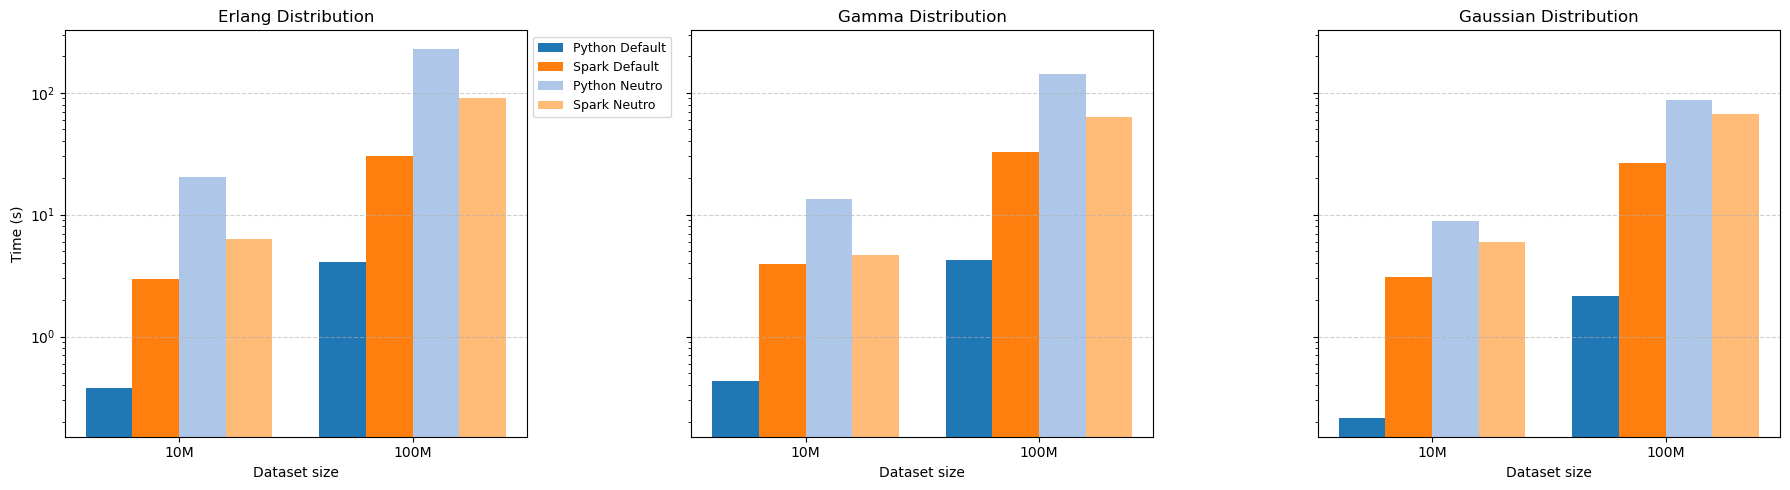

In [4]:
import time
import math
import random
import numpy as np
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
sizes = [10**7, 10**8]  # dataset sizes
distributions = ["Erlang", "Gamma", "Gaussian"]

fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
width = 0.2
for ax, dist in zip(axes, distributions):
    labels = [f"{s//10**6}M" for s in sizes]
    x = np.arange(len(labels))
    
    py_default = [results[dist]["Default"][s]["Python"] for s in sizes]
    sp_default = [results[dist]["Default"][s]["Spark"] for s in sizes]
    py_neutro  = [results[dist]["Neutrosophic"][s]["Python"] for s in sizes]
    sp_neutro  = [results[dist]["Neutrosophic"][s]["Spark"] for s in sizes]
    
    ax.bar(x - 1.5*width, py_default, width, label="Python Default", color="#1f77b4")
    ax.bar(x - 0.5*width, sp_default, width, label="Spark Default",  color="#ff7f0e")
    ax.bar(x + 0.5*width, py_neutro,  width, label="Python Neutro",  color="#aec7e8")
    ax.bar(x + 1.5*width, sp_neutro,  width, label="Spark Neutro",   color="#ffbb78")
    
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_yscale("log")
    ax.set_title(f"{dist} Distribution")
    ax.set_xlabel("Dataset size")
    ax.grid(axis="y", linestyle="--", alpha=0.6)


axes[0].set_ylabel("Time (s)")
axes[0].legend(fontsize=9, loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()